In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.colors as colors
from matplotlib.patches import Ellipse
%matplotlib inline
import math
import fitClus2D as fc
from scipy.stats import sigmaclip
from multiprocessing import Pool
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from multiprocessing import Pool
import RunParallel as rp

import astropy
from astropy.stats import sigma_clip
from astropy.io import fits
from astropy.wcs import WCS
from astropy.cosmology import FlatLambdaCDM

from PIL import Image

# These cuts get you a 4x4 arcmin square centered on the image center of the fields
img_cuts = {'a2744':[[519,4520],[412,4413]],
            'm0416':[[367,4368],[380,4381]]}
img_files = {'a2744':'Files/abell2744_RGB.fits',
             'm0416':'Files/macs0416_RGB.fits'}

zclus = {'a2744' : 0.308,
         'm0416' : 0.396}
pgals = {'a2744' : [1.689791e-01, 1.965115e+00, 2.0],
        'm0416' : [3.737113e-01, 1.322081e+00, 2.0]}


Read image data from file Files/a2744_images_0.5.dat
Read halo data from file Files/a2744halo.dat
Read deflection data from file Files/a2744_def1-los.pkl
Read image data from file Files/m0416_images.dat


In [2]:
cluster = 'm0416'
catalog = "Files/" + cluster + "_master_cleaned.csv"

#Set up clusters, not clusters, and unknowns
dzcut=0.02; sigclip=3; sigcut=3; radialcut=120; maglim=23.5; colorcut=1.0
master = pd.read_csv(catalog)
zdat = master['master_z']
valid = master['master_valid']
memberindx = np.where((zdat>zclus[cluster]-dzcut)&(zdat<zclus[cluster]+dzcut)&(valid==1))[0]
z1 = zdat[memberindx]
z2 = sigma_clip(z1,sigma=sigclip)
print(np.mean(z2),np.std(z2))

dz = sigcut*np.std(z2)
print(dz)
ddat = master['master_d']
zdat = master['master_z']
mag814 = master['master_mag814']
mag606 = master['master_mag606']
valid = master['master_valid']
master_cut = master.iloc[np.where((ddat<radialcut)&(~np.isnan(mag606))&(~np.isnan(mag814))&(mag814<=maglim)&(valid == 1))]

zdat   = master_cut['master_z']
nmemindx = np.where((zdat<zclus[cluster]-dz)|(zdat>zclus[cluster]+dz))[0]
memindx = np.where((zdat>zclus[cluster]-dz)&(zdat<zclus[cluster]+dz))[0]
unknownindx = np.where(np.isnan(zdat))[0]

clusterarr = [master_cut.iloc[i] for i in memindx]
ncluster =[master_cut.iloc[i] for i in nmemindx]
unknown = [master_cut.iloc[i] for i in unknownindx]

XclustCM= [[row['master_mag814'], row['master_mag606'] - row['master_mag814']] for row in clusterarr]
XnclustCM = [[row['master_mag814'], row['master_mag606'] - row['master_mag814']] for row in ncluster]
Xcm = np.array(XclustCM + XnclustCM)

Xclustall= [[row['master_mag814'], row['master_mag606'] - row['master_mag814'], row['master_d']] for row in clusterarr]
Xnclustall = [[row['master_mag814'], row['master_mag606'] - row['master_mag814'], row['master_d']] for row in ncluster]
Xall = np.array(Xclustall + Xnclustall)

unknownXcm = [[row['master_mag814'], row['master_mag606'] - row['master_mag814']] for row in unknown]
unknownXcm = np.array(unknownXcm)

y = np.zeros(len(clusterarr) + len(ncluster))
y[:len(clusterarr)] = 1

clustnum = len(clusterarr)
nclustnum = len(ncluster)
print(len(memindx))
print(len(nmemindx))
print(len(unknownindx))


0.3960252040816326 0.007215352640991353
0.02164605792297406
146
90
125


In [3]:
#Set up images
cosmo = FlatLambdaCDM(H0 = 70, Om0 = 0.3)
imgdat = fc.imgclass("Files/" + cluster + "_images.dat", zclus[cluster], cosmo)
print(len(imgdat.xarr))

Read image data from file Files/m0416_images.dat
95


In [4]:
#Ways to assign probabilities
def normalize(X, p):
    copyX = np.copy(X)
    copyp = np.copy(p)
    for i in range((len(X[0]))):
        mn = np.min(X[:,i])
        mx = np.max(X[:,i])
        copyX[:,i] = (X[:,i] - mn) / (mx - mn)
        copyp[:,i] = (p[:,i] - mn) / (mx - mn)
    
    return copyX, copyp
    
def Knn(X, y, p, k):
    normX, normp = normalize(X, p)
    model = KNeighborsClassifier(n_neighbors = k)
    model.fit(normX, y)
    return model.predict_proba(normp)[:,1], model.predict(normp)

def Rnn(X, y, p, r):
    normX, normp = normalize(X, p)
    model = RadiusNeighborsClassifier(radius = r, outlier_label = 0)
    model.fit(normX, y)
    return model.predict_proba(normp)[:,1], model.predict(normp)

def box(X, y, p, numx, numy):
    minm = np.min(Xcm[:,0])
    maxm = np.max(Xcm[:,0])
    minc = np.min(Xcm[:,1])
    maxc = np.max(Xcm[:,1])
    w = maxm - minm
    h = maxc - minc
    minm -= 0.01 * w
    maxm += 0.01 * w
    minc -= 0.01 * h
    maxc += 0.01 * h
    
    boxw = (maxm - minm) / numx
    boxh = (maxc - minc) / numy
    grid = np.zeros((numx, numy, 2))
    
    for i, point in enumerate(X):
        xcoor = int((point[0] - minm) / boxw)
        ycoor = int((point[1] - minc) / boxh)
        grid[xcoor, ycoor, 1] += 1
        grid[xcoor, ycoor, 0] += y[i]
        
    probs = np.zeros(len(p))
    classes = np.zeros(len(p))
    
    for i, point in enumerate(p):
        if point[0] >= minm and point[0] < maxm and point[1] >= minc and point[1] <= maxc:
            xcoor = int((point[0] - minm) / boxw)
            ycoor = int((point[1] - minc) / boxh)
            if not grid[xcoor, ycoor, 1] == 0:
                probs[i] = grid[xcoor, ycoor, 0] / grid[xcoor, ycoor, 1]
                if probs[i] > 0.5: classes[i] = 1
                    
    return probs, classes

def sigmaCut(X, y, p, k):
    clustermag = [dat[0] for i, dat in enumerate(X) if y[i] == 1]
    clustercolor = [dat[1] for i, dat in enumerate(X) if y[i] == 1]
    
    model = np.polyfit(clustermag, clustercolor, 1)
    predict = np.poly1d(model)
    
    res = clustercolor - predict(clustermag)
    sigma = np.std(res)
    
    probs = np.zeros(len(p))
    classes = np.zeros(len(p))
    
    nclust = 0
    ntot = 0
    
    for i, point in enumerate(X):
        if abs(point[1] - predict(point[0])) < k * sigma:
            if y[i] == 1:
                nclust += 1
            ntot += 1
    prob = nclust / ntot
    
    for i, point in enumerate(p):
        if abs(point[1] - predict(point[0])) < k * sigma:
               probs[i] = prob
               classes[i] = 1
    return probs, classes

In [5]:
clusterData = [[row['master_x'], row['master_y'], row['master_mag814'], 1] for row in clusterarr]
unknownData = [[row['master_x'], row['master_y'], row['master_mag814'], 0] for row in unknown]
data = np.array(clusterData + unknownData)


In [6]:
#Get probability arrays
knnprob = Knn(Xcm, y, unknownXcm, 16)[0]
rnnprob = Rnn(Xcm, y, unknownXcm, 0.15)[0]
boxprob = box(Xcm, y, unknownXcm, 2, 14)[0]
sigmaclass = sigmaCut(Xcm, y, unknownXcm, 1.0)[1]

print(np.sum(sigmaclass))

61.0


In [7]:
def writegal(probs, fname):
    data[clustnum:, 3] = probs
    galdata = data.tolist()
    galdata.sort(key=lambda x: x[2])
    
    
    f = open(fname, "a")
    for gal in galdata:
        f.write(str(gal[0]) + " " + str(gal[1]) + " " + str(gal[2]) + " " + str(gal[3]) + "\n")
        
    f.close()

In [28]:
#write galaxy parameters 

writegal(sigmaclass, "Files/GalaxyData/m0416-def-sigma.txt")
writegal(knnprob, "Files/GalaxyData/m0416-def-knn.txt")
writegal(rnnprob, "Files/GalaxyData/m0416-def-rnn.txt")
writegal(boxprob, "Files/GalaxyData/m0416-def-box.txt")

In [9]:
data[clustnum:, 3] = sigmaclass
print(sum(data))

[ 783.93176496 -194.35023622 5890.30552392  207.        ]


In [10]:
if __name__ == '__main__':
    num_processors = 4
    #Create a pool of processors
    p=Pool(processes = num_processors)

    #get them to work in parallel
    ret = p.map(rp.makefile,[i for i in range(num_processors)])

In [35]:
makefile("Files/GalaxyData/a2744-def-sigma.txt", "Files/Deflections/a2744-sigma-defs")
makefile("Files/GalaxyData/a2744-def-knn.txt", "Files/Deflections/a2744-knn-defs")
makefile("Files/GalaxyData/a2744-def-rnn.txt", "Files/Deflections/a2744-rnn-defs")
makefile("Files/GalaxyData/a2744-def-box.txt", "Files/Deflections/a2744-box-defs")

Read galaxy data from file Files/GalaxyData/a2744-def-sigma.txt
Generating deflection distribution: a = 1.0
Step 0
Step 500
Step 1000
Step 1500
Step 2000
Step 2500
Generating deflection distribution: a = 1.05
Step 0
Step 500
Step 1000
Step 1500
Step 2000
Step 2500
Generating deflection distribution: a = 1.1
Step 0
Step 500
Step 1000
Step 1500
Step 2000
Step 2500
Generating deflection distribution: a = 1.15
Step 0
Step 500
Step 1000
Step 1500
Step 2000
Step 2500
Generating deflection distribution: a = 1.2
Step 0
Step 500
Step 1000
Step 1500
Step 2000
Step 2500
Generating deflection distribution: a = 1.25
Step 0
Step 500
Step 1000
Step 1500
Step 2000
Step 2500
Generating deflection distribution: a = 1.3
Step 0
Step 500
Step 1000
Step 1500
Step 2000
Step 2500
Generating deflection distribution: a = 1.35
Step 0
Step 500
Step 1000
Step 1500
Step 2000
Step 2500
Generating deflection distribution: a = 1.4
Step 0
Step 500
Step 1000
Step 1500
Step 2000
Step 2500
Generating deflection distributi

Step 500
Step 1000
Step 1500
Step 2000
Step 2500
Generating deflection distribution: a = 1.8
Step 0
Step 500
Step 1000
Step 1500
Step 2000
Step 2500
Generating deflection distribution: a = 1.85
Step 0
Step 500
Step 1000
Step 1500
Step 2000
Step 2500
Generating deflection distribution: a = 1.9
Step 0
Step 500
Step 1000
Step 1500
Step 2000
Step 2500
Generating deflection distribution: a = 1.9500000000000002
Step 0
Step 500
Step 1000
Step 1500
Step 2000
Step 2500
Generating deflection distribution: a = 2.0
Step 0
Step 500
Step 1000
Step 1500
Step 2000
Step 2500
Generating deflection distribution: a = 2.05
Step 0
Step 500
Step 1000
Step 1500
Step 2000
Step 2500
Generating deflection distribution: a = 2.1
Step 0
Step 500
Step 1000
Step 1500
Step 2000
Step 2500
Generating deflection distribution: a = 2.1500000000000004
Step 0
Step 500
Step 1000
Step 1500
Step 2000
Step 2500
Generating deflection distribution: a = 2.2
Step 0
Step 500
Step 1000
Step 1500
Step 2000
Step 2500
Generating deflecti

Read deflection data from file Files/m0416-def1-scale1.pkl
[1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65
 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35
 2.4  2.45 2.5 ]
Read deflection data from file Files/Deflections/m0416-box-defs.pkl
[0.98341678 0.1518362 ]


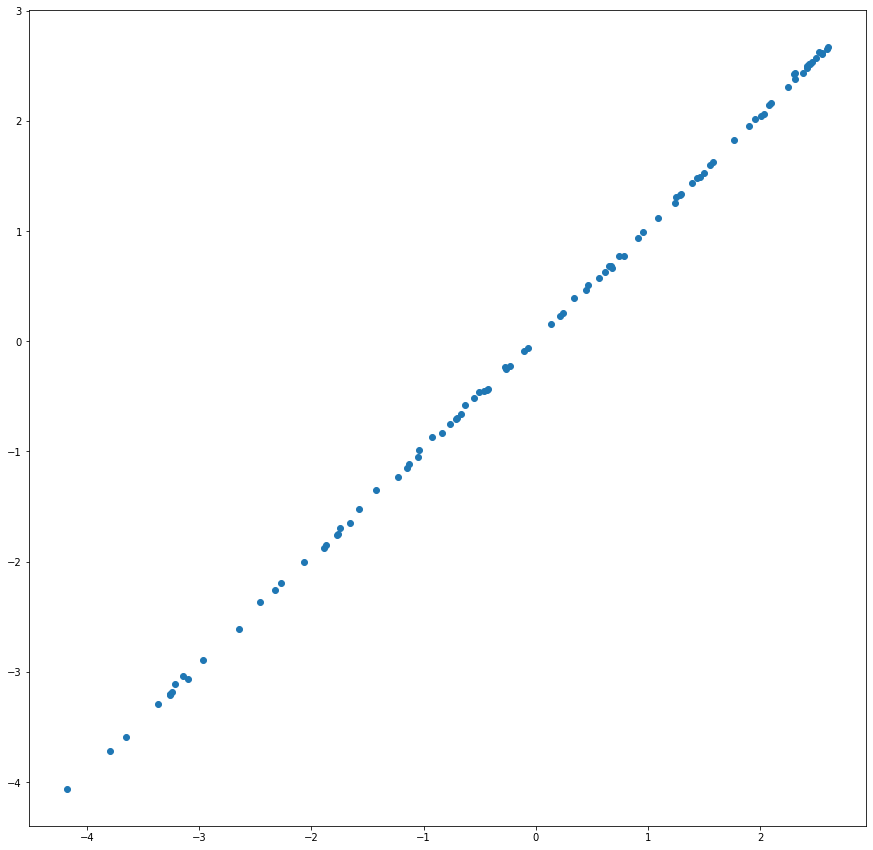

In [18]:
#test compparison
compdef = fc.defclass()
compdef.load("Files/m0416-def1-scale1")

print(compdef.aarr)

mydef = fc.defclass()
mydef.load("Files/Deflections/m0416-box-defs")

fig, ax = plt.subplots(figsize = (15, 15))
ax.scatter(compdef.marr[12,:,0], mydef.marr[12,:,0])

model = np.polyfit(mydef.marr[30,:,1], compdef.marr[30,:,1], 1)
print(model)
# sigdef = fc.defclass()
# sigdef.load("Files/Deflections/a2744-sigma-defs")

# knndef = fc.defclass()
# knndef.load("Files/Deflections/a2744-knn-defs")

# rnndef = fc.defclass()
# rnndef.load("Files/Deflections/a2744-rnn-defs")

# boxdef = fc.defclass()
# boxdef.load("Files/Deflections/a2744-box-defs")

[1.00022897 0.0026545 ]
[ 0.98055017 -0.01196777]
[0.95609372 0.02456215]
[0.95612678 0.02708583]


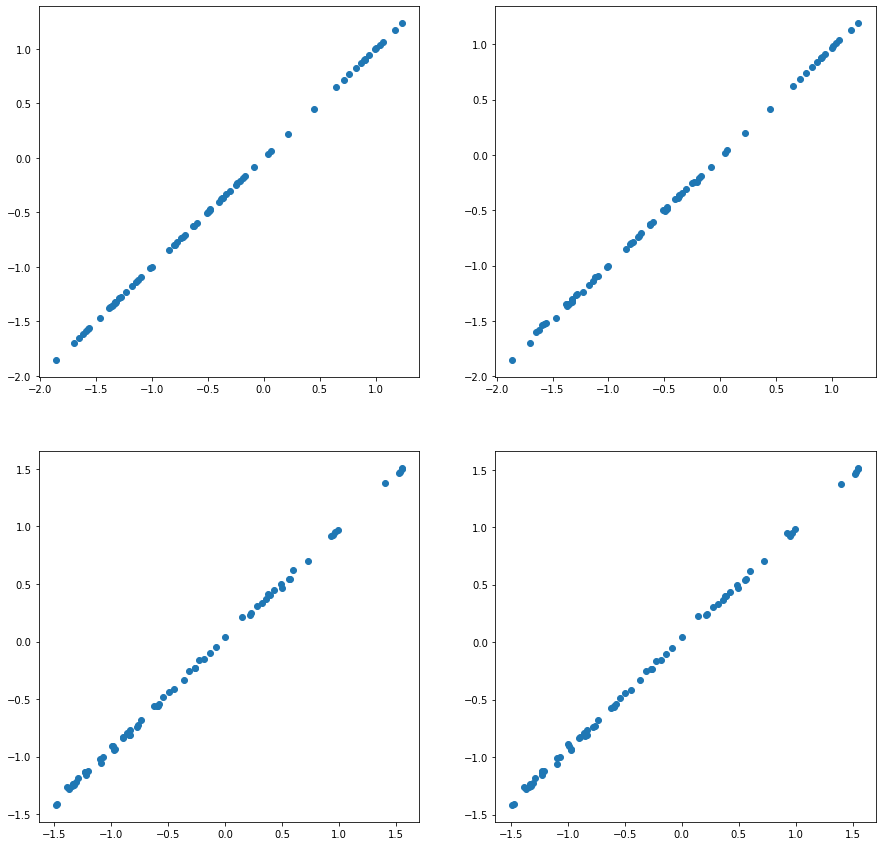

In [30]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (15, 15))

test = 0
ax1.scatter(compdef.marr[test,:,1], sigdef.marr[test,:,1])

ax2.scatter(compdef.marr[test,:,1], knndef.marr[test,:,1])

ax3.scatter(compdef.marr[test,:,0], rnndef.marr[test,:,0])

ax4.scatter(compdef.marr[test,:,0], boxdef.marr[test,:,0])

sigmodel = np.polyfit(compdef.marr[test,:,1], sigdef.marr[test,:,1], 1)
print(sigmodel)

knnmodel = np.polyfit(compdef.marr[test,:,1], knndef.marr[test,:,1], 1)
print(knnmodel)

rnnmodel = np.polyfit(compdef.marr[test,:,0], rnndef.marr[test,:,0], 1)
print(rnnmodel)

boxmodel = np.polyfit(compdef.marr[test,:,0], boxdef.marr[test,:,0], 1)
print(boxmodel)